In [1]:
import torch
import cv2
from segment_anything import sam_model_registry, SamPredictor
from segment_anything import SamAutomaticMaskGenerator_mod2 as SamAutomaticMaskGenerator
import numpy as np
import matplotlib.pyplot as plt
import glob
import torch
import functions as fnc
from importlib import reload
import gc
from skimage.measure import label, regionprops
from collections import Counter
from torchvision.ops.boxes import batched_nms
from sklearn.neighbors import KDTree
import matplotlib.colors as mcolors
import os
import time
import sys
import json
import pandas as pd
from contextlib import redirect_stdout
import First_second_fnc as FS_fnc

In [9]:
OutDIR='/DATA/vito/output/ran_synth_02_1500_cl_std_192/ran_synth_02_1500_cl_std_192_00_b250/'

In [7]:
n_pass=0

In [10]:
with open(OutDIR+'init_para.json', 'r') as json_file:
    init_para = json.load(json_file)[n_pass]
print('Loaded parameters from json')
print(init_para)

Loaded parameters from json
{'OutDIR': '/DATA/vito/output/ran_synth_02_1500_cl_std_192/ran_synth_02_1500_cl_std_192_00_b250/', 'DataDIR': '/DATA/vito/data/', 'DatasetName': 'ran_synth_02_1500_cl_std_192/img/*', 'fid': 0, 'crop_size': 1024, 'resample_factor': 1, 'point_per_side': 30, 'dilation_size': 15, 'b': 100, 'stability_t': 0.85, 'third_b_resample_factor': 0.08333333333333333, 'resolution(mm)': 0.2, 'expected_min_size(sqmm)': 0, 'min_radius': 0}


In [11]:
OutDIR=init_para.get('OutDIR')
DataDIR=init_para.get('DataDIR')
DSname=init_para.get('DatasetName')
fid=init_para.get('fid')
pps=init_para.get('point_per_side')
#window_step=init_para.get('window_step')
b=init_para.get('b')
stb_t=init_para.get('stability_t')
#defining clips
crop_size=init_para.get('crop_size')
resample_factor=init_para.get('resample_factor')
min_pixel=(init_para.get('expected_min_size(sqmm)')/(init_para.get('resolution(mm)')**2))*resample_factor
min_radi=init_para.get('min_radius')
print(f'Minimum expected size: {min_pixel} pixel')

Minimum expected size: 0.0 pixel


In [12]:

pre_para={'Resample': {'fxy':resample_factor},
        #'Gaussian': {'kernel size':3}
        #'CLAHE':{'clip limit':2}#,
        #'Resample': {'fxy':4},
        #'Buffering': {'crop size': crop_size}
        }
try:#attempt to load saved init_para
    with open(OutDIR+'pre_para.json', 'r') as json_file:
        init_para = json.load(json_file)
    print('Loaded preprocessing parameters from json')
    print(pre_para)
except:#use defined init_para
    print('Using preprocessing default')
    print(pre_para)

Loaded preprocessing parameters from json
{'Resample': {'fxy': 1}}


In [13]:
#Prep
#load image
image=fnc.load_image(DataDIR,DSname,fid)
print('Image size:', image.shape)
image=fnc.preprocessing_roulette(image, pre_para)

patches = fnc.get_image_patches(image, crop_size, 2*b)
print(f'Tiled into {len(patches)} patches')
patch_keys=patches.keys()
max_ij=np.max(np.array(list(patch_keys)),axis=0)

img_00.npy imported
Image size: (10000, 10000, 3)
Not resampling
Tiled into 144 patches


In [14]:
#setup SAM
MODEL_TYPE = "vit_h"
DEVICE, CHECKPOINT_PATH=fnc.set_sam(MODEL_TYPE,DataDIR)

sam = sam_model_registry[MODEL_TYPE](checkpoint=CHECKPOINT_PATH)
sam.to(device=DEVICE)
mask_generator = SamAutomaticMaskGenerator(sam)

Currently running on GPU
Model vit_h


/DATA/vito/.venv/lib/python3.12/site-packages/segment_anything/build_sam.py:105: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(f)


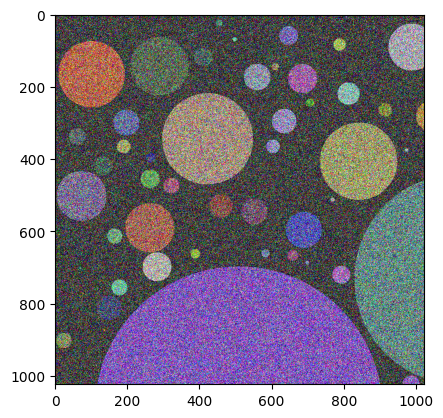

In [16]:
plt.imshow(patches[(0,0)])
plt.show()

In [32]:
stats_list=[]
ij_idx=(0,0)
print(f'Segmenting clip: {ij_idx}')
#prepare image
temp_image=patches[ij_idx]
if (temp_image.shape[0]>(crop_size//4) and temp_image.shape[1]>(crop_size//4)):
    if len(np.unique(temp_image))>1:
        #clear gpu ram
        gc.collect()
        torch.cuda.empty_cache()

        #SAM segmentation
        mask_generator = SamAutomaticMaskGenerator(
            model=sam,
            points_per_side=pps,
            pred_iou_thresh=0,
            stability_score_thresh=stb_t,#iou by varying cutoff in binary conversion
            box_nms_thresh=0.3,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks
            crop_n_layers=0,#cut into 2**n crops
            crop_nms_thresh=0,#The box IoU cutoff used by non-maximal suppression to filter duplicate masks between crops
            crop_n_points_downscale_factor=1,
            crop_overlap_ratio=0,
        )
        predictor = SamPredictor(sam)
        predictor.set_image(temp_image)

        with torch.no_grad():
            masks = mask_generator.generate(temp_image)
        print('First pass SAM: ', len(masks),' mask(s) found')

        #post processing
        #filter output mask per point by select highest pred iou mask
        masks=FS_fnc.filter_by_pred_iou_and_size_per_seedpoint(masks, crop_size)
        print('Filtered by highest predicted iou per seed point, ', len(masks),' mask(s) remains')

        list_of_pred_iou = [mask['predicted_iou'] for mask in masks]
        list_of_masks = [fnc.clean_mask(mask['segmentation'].astype('bool')) for mask in masks]#remove small disconnected parts
        no_area_after_cleaning=np.array([np.sum(mask)==0 for mask in list_of_masks])
        area_radi=np.array([fnc.area_radi(mask, min_pixel, min_radi) for mask in list_of_masks])
        if np.any(no_area_after_cleaning):
            list_of_masks = [mask for mask, keep in zip(list_of_masks, ~no_area_after_cleaning) if keep]
            list_of_pred_iou = [iou for iou, keep in zip(list_of_pred_iou, ~no_area_after_cleaning) if keep]
        if not np.all(area_radi):
            list_of_masks = [mask for mask, keep in zip(list_of_masks, area_radi) if keep]
            list_of_pred_iou = [iou for iou, keep in zip(list_of_pred_iou, area_radi) if keep]
        #remove background/edge mask
        flattened_rgb=np.sum(temp_image,axis=2)
        not_background_mask=np.array([np.any(flattened_rgb[mask.astype('bool')]>0) for mask in list_of_masks])
        if not np.all(not_background_mask):
            list_of_masks = [mask for mask, keep in zip(list_of_masks, not_background_mask) if keep]
            list_of_pred_iou = [mask for mask, keep in zip(list_of_pred_iou, not_background_mask) if keep]
            print('Background masks removed')
        
        if len(list_of_masks)>0:
            #grouping overlaps
            list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms=[],[]
            group_overlap_area, unique_groups, list_overlap = FS_fnc.Groupping_masks(list_of_masks)
            unique_groups_thresholded = FS_fnc.filter_groupping_by_intersection(group_overlap_area,unique_groups, list_overlap)
            cleaned_groups, list_of_nooverlap_mask = FS_fnc.checking_remaining_ungroupped(list_of_masks, unique_groups_thresholded, masks)
            if cleaned_groups:
                list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score = FS_fnc.Guided_second_pass_SAM(cleaned_groups, min_pixel, min_radi, list_of_masks, predictor)
                if len(list_of_nooverlap_mask)>0:
                    for m in list_of_nooverlap_mask:
                        list_of_cleaned_groups_reseg_masks.append(list_of_masks[m].astype('bool'))
                        list_of_cleaned_groups_reseg_score.append(list_of_pred_iou[m])
                list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms = fnc.nms(list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score)
                print('Found ',len(list_of_cleaned_groups_reseg_score_nms), ' mask(s)/object(s) in the clip')
            else:
                list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score = list_of_masks, list_of_pred_iou
                list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms = fnc.nms(list_of_cleaned_groups_reseg_masks, list_of_cleaned_groups_reseg_score)
                print(f'No groups were found, found {len(list_of_cleaned_groups_reseg_masks)} mask(s) from the first pass')
                print(f'{len(list_of_cleaned_groups_reseg_masks_nms)} left after nms filtering')

            #valid box
            if len(list_of_cleaned_groups_reseg_masks_nms)>0:
                keep = [fnc.mask_in_valid_box(mask,b, ij_idx, max_ij) for mask in list_of_cleaned_groups_reseg_masks_nms]
                list_of_cleaned_groups_reseg_masks_nms=[list_of_cleaned_groups_reseg_masks_nms[i] for i,k in enumerate(keep) if k]
                list_of_cleaned_groups_reseg_score_nms=[list_of_cleaned_groups_reseg_score_nms[i] for i,k in enumerate(keep) if k]
                if len(list_of_cleaned_groups_reseg_masks_nms)>0:
                    chunk_stats=fnc.create_stats_df(list_of_cleaned_groups_reseg_masks_nms,resample_factor)
                    chunk_stats['centroid y'] += (ij_idx[1]*(crop_size-2*b))/resample_factor
                    chunk_stats['centroid x'] += (ij_idx[0]*(crop_size-2*b))/resample_factor
                    stats_list.append(chunk_stats)
                    #saving outputs
                    msk_dic={#'mask':list_of_cleaned_groups_reseg_masks,
                                'nms mask':list_of_cleaned_groups_reseg_masks_nms,
                                #'mask pred iou':list_of_cleaned_groups_reseg_score,
                                'nms mask pred iou': list_of_cleaned_groups_reseg_score_nms,
                                'ij':ij_idx,'crop size':crop_size}
                    np.save(OutDIR+f'chunks/chunk_{int(ij_idx[0])}_{int(ij_idx[1])}',[msk_dic])
                    #del msk_dic, list_of_cleaned_groups_reseg_masks_nms, list_of_cleaned_groups_reseg_score_nms
            else:
                print('No valid mask were found')
        else:
            print('No valid mask were found')
    else:
        print('This crop is bacground/edge')
else:
    print('This crop is too small')            

Segmenting clip: (0, 0)
First pass SAM:  1218  mask(s) found
Filtered by highest predicted iou per seed point,  525  mask(s) remains
Threshold: 1000 pixels, 519030 groups removed 
Overlap groups before filtering: 519063, after filtering: 33
Found  74  mask(s)/object(s) in the clip


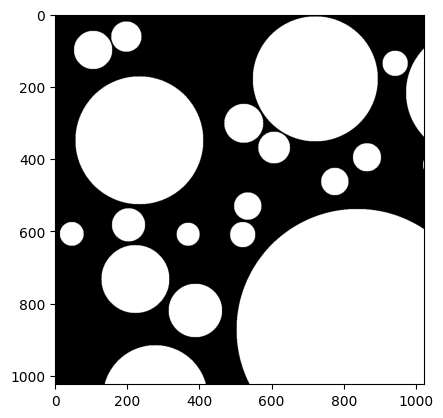

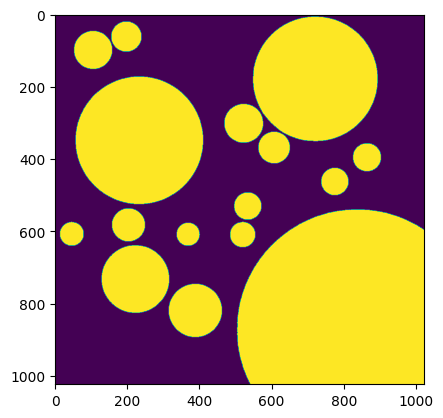

In [31]:
plt.imshow(patches[(0,0)])
plt.show()
plt.imshow(np.sum(list_of_cleaned_groups_reseg_masks_nms,axis=0))
